In [1]:
import optuna
import flappy_bird_gymnasium
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import randint
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import time
import os
import json
import random


In [2]:
import gymnasium as gym
import math
import numpy as np
import pandas as pd
from pathlib import Path

from typing import cast, List, Optional, Sequence, Tuple, Union

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [4]:
from IPython.display import Video
sns.set_context("talk")

## Enregistrer les variables d'entrainement

In [5]:
import pickle

# Variable à sauvegarder
data = {"state1": [0.5, 0.7], "state2": [1.0, -0.2]}

# Sauvegarde dans un fichier Pickle
def save_variable_in_pickle(data, name_file):
    with open(name_file, "wb") as f:
        pickle.dump(data, f)

def load_variable_pickel(name_file):
    # Charger les données
    with open(name_file, "rb") as f:
        loaded_data = pickle.load(f)
    return loaded_data

save_variable_in_pickle(data, "data/test.pkl")
new_data = load_variable_pickel("data/test.pkl")
print(new_data)

{'state1': [0.5, 0.7], 'state2': [1.0, -0.2]}


## Customisation de Reward / Observations dans Gymnasium

CUSTOM REWARD in flappy bird gymnasium

In [6]:
class CustomRewardWrapperFlappyBird(gym.Wrapper):
    """custom reward wrapper to change the reward of the gymnasium environement of Flappy Bird
        Before
        +0.1 - every frame it stays alive
        +1.0 - successfully passing a pipe
        -1.0 - dying
        −0.5 - touch the top of the screen
        After
        Reward dead : -1000
        Reward alive : 0
    """
    def __init__(self, env, reward_alive=1, reward_die=-5):
        super().__init__(env)
        self.reward_alive = reward_alive
        self.reward_die = reward_die


    def step(self, action):
        # TO DO : a modifier plus tard
        obs, reward, done, truncated, info = self.env.step(action)
        
        # version extreme
        if done:
            reward = -1000
        else: 
            reward = 0
        # if reward== 1 :
        #     reward = 5.0  # On augmente la récompense des tuyaux
        # elif reward == 0.1:
        #     reward = 0.1  # Chaque frame survivante reste inchangée
        # elif reward == -1.0:
        #     reward = -3.0  # Pénalité pour mourir
        # elif reward == -0.5:
        #     reward = -0.5  # Pénalité pour toucher le haut de l'écran
        
        return obs, reward, done, truncated, info
    
env = gym.make("FlappyBird-v0", use_lidar=False, normalize_obs = True)
env = CustomRewardWrapperFlappyBird(env, reward_alive=0, reward_die=-1000)

CUSTOM OBSERVATION FORMAT in Flappy Bird Environnement

In [7]:
import numpy as np

def extract_state(obs, player_x=0):
    """
    Extrait les variables nécessaires pour Q-learning à partir de l'observation.
    
    Variables retournées :
    - x0 : Distance horizontale entre le joueur et le prochain tuyau inférieur.
    - y0 : Distance verticale entre le joueur et le bas du prochain tuyau.
    - vel : Vitesse verticale du joueur.
    - y1 : Distance verticale entre le joueur et le tuyau inférieur suivant.
    
    :param obs: np.array contenant les observations de l'environnement.
    :param player_x: Position horizontale du joueur (souvent 0 si fixe).
    :return: (x0, y0, vel, y1)
    """
    # Distance horizontale au prochain tuyau (x0)
    x0 = obs[3] - player_x  # next pipe horizontal pos - player horizontal pos

    # Distance verticale au bas du prochain tuyau (y0)
    y0 = obs[9] - obs[5]  # player vertical pos - next bottom pipe vertical pos

    # Vitesse verticale du joueur (vel)
    vel = obs[10]  

    # Distance verticale au bas du tuyau suivant (y1)
    y1 = obs[9] - obs[8]  # player vertical pos - next next bottom pipe vertical pos

    return x0, y0, vel, y1


In [8]:
class CustomObservationWrapper(gym.ObservationWrapper):
    """
    Wrapper to modify the observation space of Flappy Bird.
    - Selects relevant features: bird_x, bird_y, velocity, distance_to_pipe.
    - Optionally discretizes the observations for Q-learning.
    """
    def __init__(self, env, discretize=False, bins=20, simplify_obs=False):
        super().__init__(env)
        self.discretize = discretize  # Discretization flag
        self.bins = bins  # Number of bins for discretization
        self.simplify_obs = simplify_obs

    def observation(self, obs):
        """
        Extracts and discretizes observation space
        If we don't discretize we can't use qlearning
        If we discretize without simplifying, we have 15^11 = 3375 states possibles (and Q_table of size 2*3375 = 6750)
        If we simplify into 3 distances and use bins=15, we have only 15^3 = 45 states possibles
        """
        # Extraction de 3 valeurs : distance horizontale au prochain pipe, 
        # la distance verticale au haut de next pipe, la distance verticale au bas de next pipe

        new_obs=obs
        
        if self.simplify_obs:
            # Extraction des valeurs pertinentes
            next_pipe_x = obs[3]  # Position horizontale du prochain pipe
            next_top_pipe_y = obs[4]  # Position verticale du haut du prochain pipe
            next_bottom_pipe_y = obs[5]  # Position verticale du bas du prochain pipe
            player_y = obs[-3]  # Position verticale du joueur

            # Calcul des features demandées
            distance_to_pipe = next_pipe_x  # Supposition que player_x = 0
            distance_to_top_pipe = player_y - next_top_pipe_y
            distance_to_bottom_pipe = player_y - next_bottom_pipe_y

            #new_obs = np.array([obs[0], obs[1], obs[2], obs[3], obs[4], obs[5], obs[9], obs[10], obs[11]], dtype=np.float32)
            new_obs = extract_state(obs)

        # Discrétisation pour Q-learning
        if self.discretize:
            new_obs = np.digitize(new_obs, np.linspace(-1, 1, self.bins)) - 1  # Convertir en indices discrets

        return new_obs

# Utilisation
env = gym.make("FlappyBird-v0", use_lidar=False)
env = CustomObservationWrapper(env, discretize=True, bins=15, simplify_obs=True)  # Discrétisation activée


Change reward and discretize observation space

In [9]:
# Initialiser l'environnement
def define_discrete_flappy_bird(change_reward=False, bins=25, simplify_obs=True):
    env = gym.make("FlappyBird-v0", use_lidar=False)
    if change_reward:
        env = CustomRewardWrapperFlappyBird(env, reward_alive=0, reward_die=-1) # Reward changée
    env = CustomObservationWrapper(env, discretize=True, bins=bins, simplify_obs=simplify_obs)  # Discrétisation activée
    return env

env = define_discrete_flappy_bird()
print(env.bins, env.simplify_obs)

25 True


Test du changement de reward/observations sur un pas

In [10]:
env = define_discrete_flappy_bird()
obs, _ = env.reset()

action = env.action_space.sample()

obs, reward, terminated, _, info = env.step(action)

print("Observation:", obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("info", info)
print("score:", info['score'])

env.close()

Observation: [24  5  1  5]
Reward: 0.1
Terminated: False
info {'score': 0}
score: 0


# QLearning sur l'espace discrétisé

avec rectification de q_array en dictionnaire comme dans le github avancé

In [11]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from typing import Dict, Tuple

DISPLAY_EVERY_N_EPISODES = 50

def get_q_values(state, q_table, num_actions):
    """Retourne les Q-values associées à un état sous forme de tuple."""
    state = tuple(state)  # Convertit l'état en tuple pour être utilisé comme clé
    if state not in q_table:
        q_table[state] = [0.0] * num_actions  # Initialisation des Q-values
    return q_table[state]


def epsilon_greedy_policy_q_dict(state, q_table, epsilon, num_actions=2):
    """Choisit une action selon la politique epsilon-greedy."""
    state = tuple(state)  # Convertit en tuple
    if np.random.rand() < epsilon:
        action = np.random.randint(num_actions)  # Exploration entre 0 et 1
    else:
        action = np.argmax(get_q_values(state, q_table, num_actions))  # Exploitation
    return action

def greedy_policy_q_dict(state, q_table, num_actions=2):
    """Choisit l'action avec la meilleure Q-value (greedy policy)."""
    state = tuple(state)  # Convertit en tuple
    return np.argmax(get_q_values(state, q_table, num_actions))

def q_learning(
    environment: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.95,
    epsilon: float = 0.5,
    num_episodes: int = 60000,
) -> Dict:
    """
    Q-learning avec une Q-table stockée dans un dictionnaire (sans sauvegarde de fichier).
    """
    q_table = {}  # Dictionnaire pour stocker les Q-values
    num_actions = environment.action_space.n  # Nombre d'actions possibles
    history_score=[]
    history_reward=[]

    for episode_index in tqdm(range(1, num_episodes + 1)):
        obs, _ = environment.reset()
        state = tuple(obs)  # Convertir l'observation en tuple (clé du dictionnaire)
        terminated = False
        cumulated_reward = 0

        while not terminated:
            # Politique epsilon-greedy
            action = epsilon_greedy_policy_q_dict(state, q_table, epsilon, num_actions)

            # Prendre une action
            obs_prime, reward, terminated, _, info = environment.step(action)
            next_state = tuple(obs_prime)  # Convertir en clé

            # Récupérer les Q-values
            q_values = get_q_values(state, q_table, num_actions)
            next_q_values = get_q_values(next_state, q_table, num_actions)  # Assure que l'état existe

            # Mise à jour de la Q-table (règle de Q-learning)
            q_values[action] += alpha * (reward + gamma * max(next_q_values) - q_values[action])

            # Mise à jour de l'état actuel
            state = next_state

            cumulated_reward += reward
        
        if episode_index % (num_episodes // 10) == 0:
            last_10_percent_scores = history_score[-(num_episodes // 10):]  # Prend les derniers 10% des scores
            print(f"Épisode {episode_index}/{num_episodes} - Moyenne cumulée {np.mean(history_score)} - Moyenne des derniers 10% : {np.mean(last_10_percent_scores)}")

        history_score.append(info['score'])
        history_reward.append(cumulated_reward)
        
        # Réduction progressive de epsilon
        epsilon = max(0.01, epsilon * 0.995)  # Diminue progressivement epsilon mais reste ≥ 0.01

    return history_score, history_reward, q_table


TO DO : Changement a faire plus tard au qlearning: rajouter un eps decay et verifier espace discret

Use QLearning on Flappy Bird with reward originelle

In [ ]:
# Utiliser QLearning
change_reward = True
env = define_discrete_flappy_bird(change_reward=change_reward, bins = 25, simplify_obs=False)
num_ep = 500000 # 40mn
history_score, history_reward, q_table = q_learning(env, num_episodes=num_ep) # 700000
save_variable_in_pickle(history_score, f"data/history_score_reward_extreme_bins_25_obs_original_ep{num_ep}.pkl")
save_variable_in_pickle(q_table, f"data/q_table_extreme_reward_ep{num_ep}_obs_original.pkl")
save_variable_in_pickle(q_table, f"data/history_reward_extreme_ep{num_ep}_obs_original.pkl")

  0%|          | 0/500000 [00:00<?, ?it/s]

 10%|█         | 50031/500000 [03:28<42:11, 177.77it/s]  

Épisode 50000/500000 - Moyenne cumulée 0.25376507530150605 - Moyenne des derniers 10% : 0.25376507530150605


 20%|██        | 100023/500000 [07:35<33:20, 199.89it/s]

Épisode 100000/500000 - Moyenne cumulée 0.32992329923299235 - Moyenne des derniers 10% : 0.40608


 30%|███       | 150059/500000 [10:10<20:08, 289.67it/s]

Épisode 150000/500000 - Moyenne cumulée 0.5421302808685391 - Moyenne des derniers 10% : 0.96654


 40%|████      | 200031/500000 [13:47<17:50, 280.09it/s] 

Épisode 200000/500000 - Moyenne cumulée 0.8014840074200371 - Moyenne des derniers 10% : 1.57954


 50%|█████     | 250031/500000 [17:27<13:40, 304.48it/s]

Épisode 250000/500000 - Moyenne cumulée 0.98000392001568 - Moyenne des derniers 10% : 1.69408


 60%|██████    | 300053/500000 [20:33<12:11, 273.46it/s]

Épisode 300000/500000 - Moyenne cumulée 1.1373237910793037 - Moyenne des derniers 10% : 1.92392


 70%|███████   | 350029/500000 [23:42<09:55, 251.99it/s]

Épisode 350000/500000 - Moyenne cumulée 1.2668207623450354 - Moyenne des derniers 10% : 2.0438


 80%|████████  | 400024/500000 [27:14<06:50, 243.81it/s]

Épisode 400000/500000 - Moyenne cumulée 1.4064385160962902 - Moyenne des derniers 10% : 2.38376


 90%|█████████ | 450046/500000 [30:56<03:09, 263.81it/s]

Épisode 450000/500000 - Moyenne cumulée 1.5159767021704493 - Moyenne des derniers 10% : 2.39228


100%|██████████| 500000/500000 [37:24<00:00, 222.77it/s]


Épisode 500000/500000 - Moyenne cumulée 1.6084712169424338 - Moyenne des derniers 10% : 2.44092


# Results

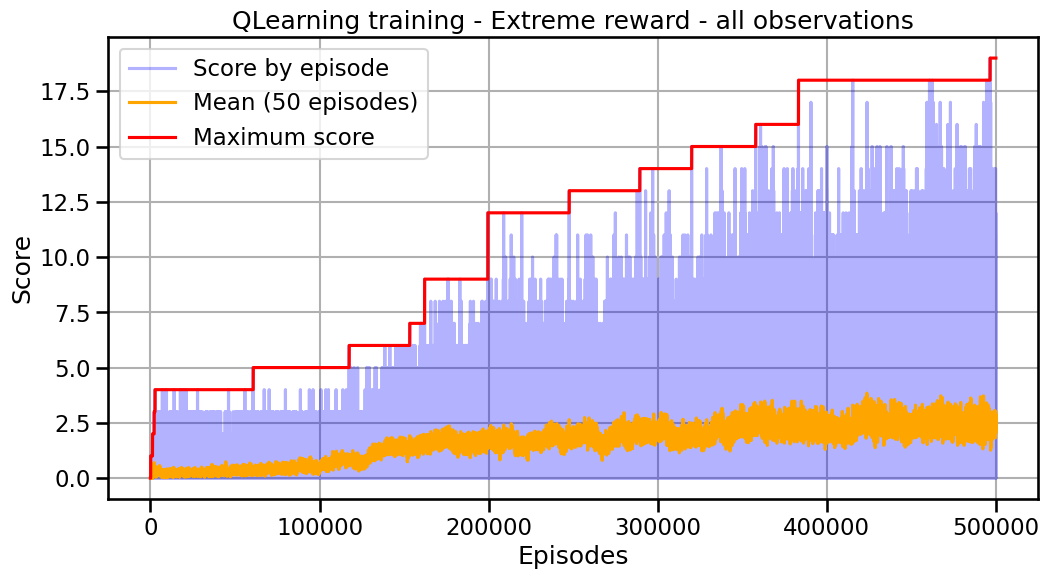

In [46]:
# Réessai de l'affichage du graphique

def plot_history_score(history_score, window=50, title="Flappy Bird - Simplified game - Evolution of scores with training"):
    """
    Affiche l'évolution des scores au fil des épisodes en RL.
    
    - Trace les scores de chaque épisode.
    - Affiche une moyenne pondérée des scores (moyenne glissante).
    - Indique le score maximal atteint à chaque épisode.
    
    :param history_score: Liste des scores obtenus à chaque épisode.
    :param window: Taille de la fenêtre pour la moyenne glissante.
    """
    num_episodes = len(history_score)
    episodes = np.arange(1, num_episodes + 1)

    avg_scores = np.convolve(history_score, np.ones(window)/window, mode='valid')

    max_scores = np.maximum.accumulate(history_score)

    plt.figure(figsize=(12, 6))
    
    sns.lineplot(x=episodes, y=history_score, label="Score by episode", alpha=0.3, color='blue')

    sns.lineplot(x=episodes[window-1:], y=avg_scores, label=f"Mean ({window} episodes)", color='orange')

    # Tracer le maximum des scores atteints
    sns.lineplot(x=episodes, y=max_scores, label="Maximum score", color='red')

    # Labels et titre
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation avec des scores simulés
plot_history_score(history_score, title="QLearning training - Extreme reward - all observations")


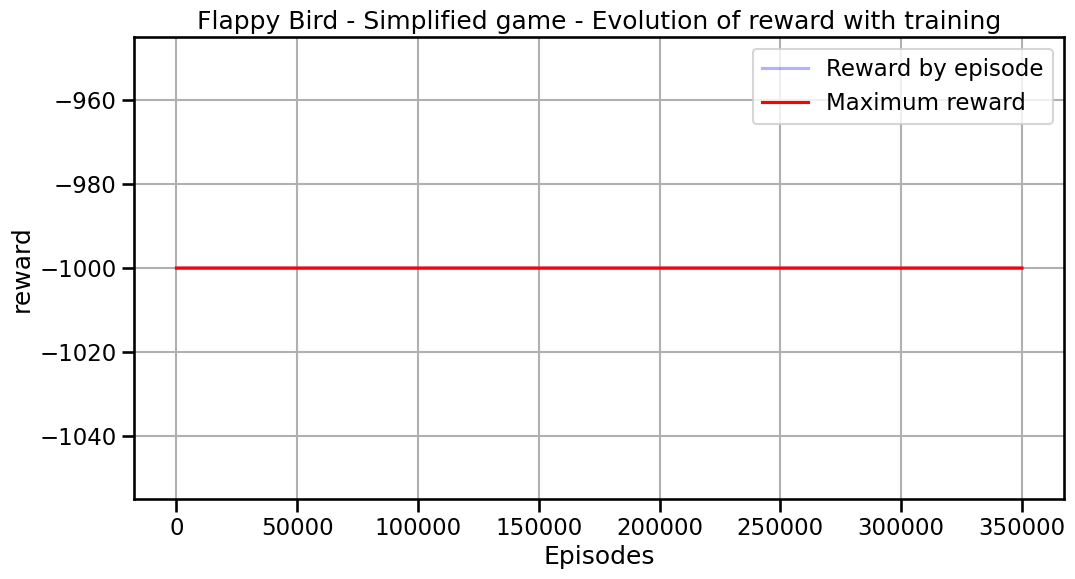

In [41]:
def plot_history_reward(history_reward, window=50, title="Flappy Bird - Simplified game - Evolution of reward with training"):
    """
    Affiche l'évolution des reward au fil des épisodes en RL.

    :param history_reward: Liste des reward obtenus à chaque épisode.
    :param window: Taille de la fenêtre pour la moyenne glissante.
    """
    num_episodes = len(history_reward)
    episodes = np.arange(1, num_episodes + 1)

    avg_reward = np.convolve(history_reward, np.ones(window)/window, mode='valid')

    max_reward = np.maximum.accumulate(history_reward)

    plt.figure(figsize=(12, 6))
    
    sns.lineplot(x=episodes, y=history_reward, label="Reward by episode", alpha=0.3, color='blue')

    #sns.lineplot(x=episodes[window-1:], y=avg_reward, label=f"Mean ({window} episodes)", color='orange')

    sns.lineplot(x=episodes, y=max_reward, label="Maximum reward", color='red')

    # Labels et titre
    plt.xlabel("Episodes")
    plt.ylabel("reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history_reward(history_reward)

Text(0, 0.5, 'scores')

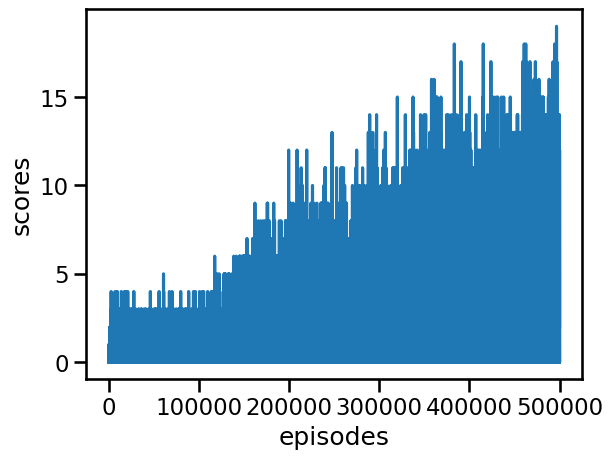

In [47]:
plt.plot( history_score)
plt.xlabel("episodes")
plt.ylabel("scores")

Evaluate Policy With Gymnasium

Average reward: 18.77958000000004
Average score: 3.3714


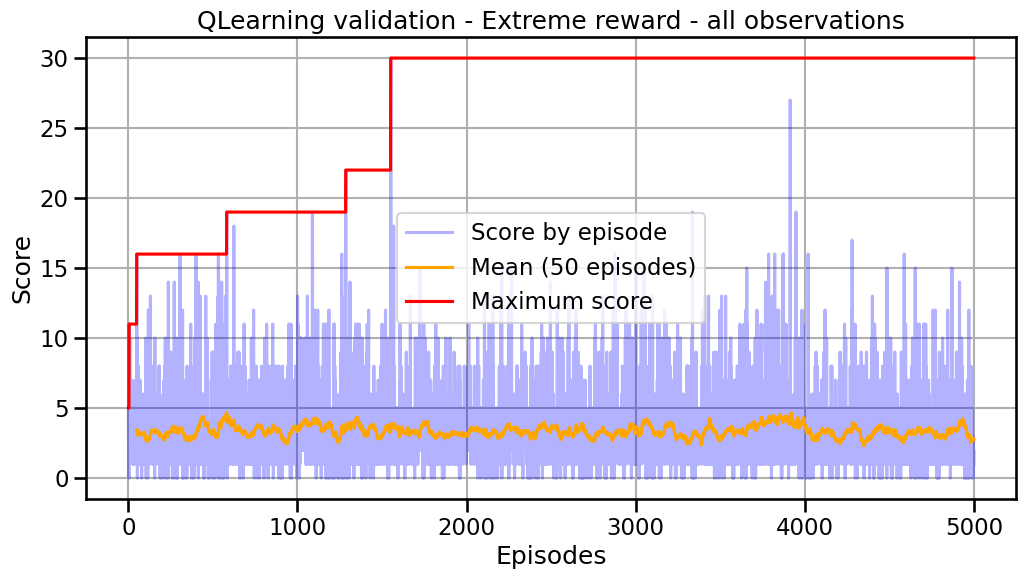

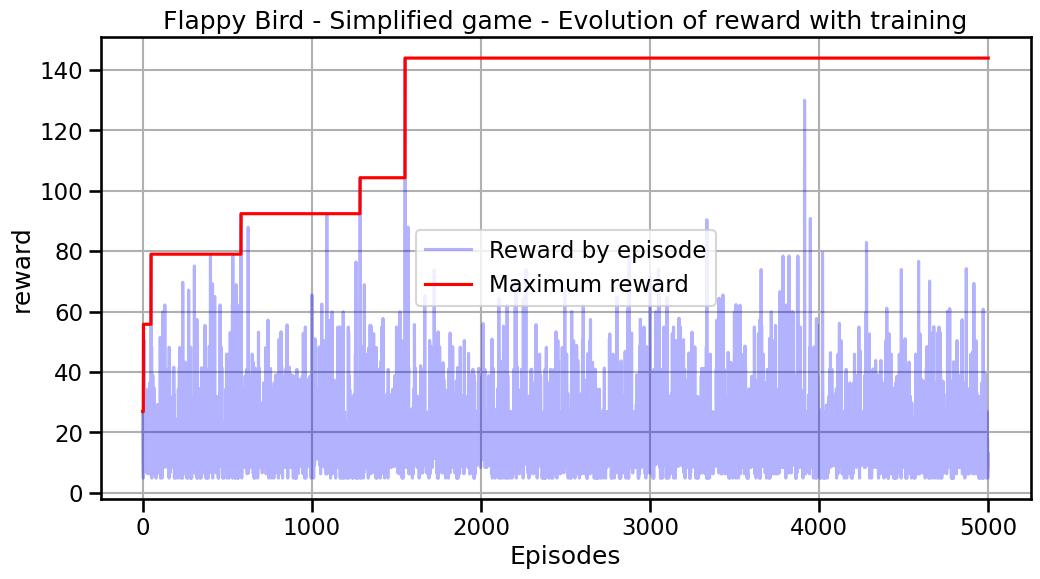

In [50]:
environment = define_discrete_flappy_bird(simplify_obs=False)

reward_list = []
score_list=[]
NUM_EPISODES = 5000

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()
    episode_over = False
    cumulated_reward=0

    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex3, epsilon)
        action = greedy_policy_q_dict(state, q_table)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated
        cumulated_reward+=reward

    reward_list.append(cumulated_reward)
    score_list.append(info['score'])

reward_df = pd.DataFrame(reward_list)
score_df = pd.DataFrame(score_list)

print(
    'Average reward:',
    np.average(reward_df),
)
print(
    'Average score:',
    np.average(score_df),
)
environment.close()

plot_history_score(score_list, title="QLearning validation - Extreme reward - all observations")
plot_history_reward(reward_list)


Text(0, 0.5, 'scores')

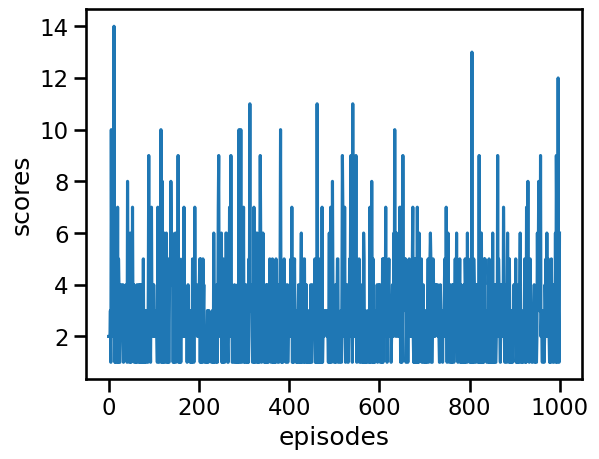

In [32]:
plt.plot(range(NUM_EPISODES), score_list)
plt.xlabel("episodes")
plt.ylabel("scores")

In [33]:
print(np.unique(score_list, return_counts=True))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([277, 245, 172, 144,  70,  35,  25,   7,  13,   6,   3,   1,   1,
         1]))


Test Optimized Policy

In [34]:
NUM_EPISODES = 5

FIGS_DIR = Path("figs/")       # Where to save figures (.gif files)

VIDEO_DIRNAME_EX3 = "lab5_ex3_qlearning"

(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-0.mp4").unlink(missing_ok=True)
(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-1.mp4").unlink(missing_ok=True)
(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-2.mp4").unlink(missing_ok=True)

environment = define_discrete_flappy_bird(simplify_obs=False)
environment = gym.wrappers.RecordEpisodeStatistics(environment, buffer_length=NUM_EPISODES)

score_list=[]

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()

    episode_over = False
    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex3, epsilon)
        action = greedy_policy_q_dict(state, q_table)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated

    reward_list.append(reward)
    #print(info)
    score_list.append(info['score'])

print(f'Episode time taken: {environment.time_queue}')
print(f'Episode total rewards: {environment.return_queue}')
print(f'Episode lengths: {environment.length_queue}')
print(f"Scores:", score_list)

environment.close()

Episode time taken: deque([0.004149, 0.003208, 0.01067, 0.002335, 0.004624], maxlen=5)
Episode total rewards: deque([8.599999999999985, 13.399999999999972, 32.60000000000017, 8.899999999999984, 8.399999999999986], maxlen=5)
Episode lengths: deque([88, 127, 283, 91, 86], maxlen=5)
Scores: [1, 2, 6, 1, 1]
